Importing packages to be used. 

In [4]:
import os
import torch
import torch.nn as nn
import torchvision
import numpy as np
import math
#import pandas as pd
import ofa
import matplotlib.pyplot as plt
import csv
import random

from ofa.imagenet_classification.networks import ResNets
from ofa.tutorial.latency_table import LatencyTable, LatencyEstimator
from torchvision import transforms, datasets
from ofa.utils.layers import (
    set_layer_from_config,
    ConvLayer,
    IdentityLayer,
    LinearLayer,
    ResidualBlock
)
from ofa.utils import make_divisible, MyNetwork, MyGlobalAvgPool2d
from ofa.utils.common_tools import download_url

Confirming the use of GPU

In [2]:
cuda_available = torch.cuda.is_available()
if cuda_available:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    print('GPU.')
else:
    print('CPU')


GPU.


Setting up the dataloader

In [5]:
if cuda_available:
    # path to the ImageNet dataset
    print("Please input the path to the ImageNet dataset.\n")
    imagenet_data_path = input()

    # if 'imagenet_data_path' is empty, download a subset of ImageNet containing 2000 images (~250M) for test
    if not os.path.isdir('/home/ssan/once-for-all-master/imagenet_1k/train/'):
        os.makedirs('/home/ssan/once-for-all-master/imagenet_1k/train/', exist_ok=True)
        download_url('https://hanlab.mit.edu/files/OnceForAll/ofa_cvpr_tutorial/imagenet_1k.zip', model_dir='data')
        ! cd data && unzip imagenet_1k 1>/dev/null && cd ..
        ! cp -r data/imagenet_1k/* $'/home/ssan/once-for-all-master/imagenet_1k/train/'
        ! rm -rf data
        print('%s is empty. Download a subset of ImageNet for test.' % imagenet_data_path)

    print('The ImageNet dataset files are ready.')
else:
    print('Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.')

Please input the path to the ImageNet dataset.

The ImageNet dataset files are ready.


In [9]:
if cuda_available:
    # The following function build the data transforms for test
    def build_val_transform(size):
        return transforms.Compose([
            transforms.Resize(int(math.ceil(size / 0.875))),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], #Color gradient could be different because of these. 
                std=[0.229, 0.224, 0.225]
            ),
        ])

    data_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(
            root=os.path.join('/home/ssan/DNN_OPTIM_Project/once-for-all-master/imagenet_1k/', 'val'),
            transform=build_val_transform(224)
        ),
        batch_size=250,  # test batch size
        shuffle=True,
        num_workers=16,  # number of workers for the data loader
        pin_memory=True,
        drop_last=False,
    )
    print('The ImageNet dataloader is ready.')
else:
    data_loader = None
    print('Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.')

The ImageNet dataloader is ready.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([250, 3, 224, 224]) 500


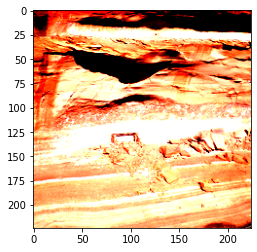

In [10]:
print(data_loader)
for i, (images, label) in enumerate(data_loader):
    print(i, images.shape, int(label[0]))
    img = images[0].permute(1,2,0)
    plt.imshow(img)
    break


Making an instance of ResNet

In [11]:
#in_features = 100
#input_stem = [ConvLayer(3, 64, kernel_size=3, stride=1, bias=False), nn.BatchNorm2d(64)]
#input_stem = LinearLayer(in_features, in_features)
input_stem = [nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3)]
blocks = [nn.Flatten(start_dim=1), nn.Linear(222*222*3,1000)]
classifier = nn.Linear(1000, 10)
resnet = ResNets(input_stem, blocks, classifier)

print(resnet)
# img=torch.rand(size=(1,3,224,224))
# print(input_stem[0](img).shape)
# print(blocks[0](input_stem[0](img)).shape)
# print(blocks[1](blocks[0](input_stem[0](img))).shape)
# print(resnet.forward(img).shape)



ResNets(
  (input_stem): ModuleList(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  )
  (max_pooling): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (blocks): ModuleList(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=147852, out_features=1000, bias=True)
  )
  (global_avg_pool): MyGlobalAvgPool2d(keep_dim=False)
  (classifier): Linear(in_features=1000, out_features=10, bias=True)
)


Obtaining the architecture of the ResNet instance. 

In [12]:
def get_architecture(net):
    architecture = {}
    for name, module in net.named_modules():
        if 'input_stem' in name:
            architecture['input_stem'] = module
        elif 'blocks' in name:
            if 'blocks' not in architecture:
                architecture['blocks'] = []
            architecture['blocks'].append(module)
        elif 'classifier' in name:
            architecture['classifier'] = module
    return architecture

architecture = get_architecture(resnet)
print(architecture)


{'input_stem': Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)), 'blocks': [ModuleList(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=147852, out_features=1000, bias=True)
), Flatten(start_dim=1, end_dim=-1), Linear(in_features=147852, out_features=1000, bias=True)], 'classifier': Linear(in_features=1000, out_features=10, bias=True)}


Getting the predicted latency

In [13]:
#lat_est = LatencyEstimator()
#pred_lat = lat_est.predict_network_latency(resnet)
#print('Predicted Latency= ', pred_lat)

Automating the creation of ResNet instances using nested loops. 

In [14]:
# in_c = random.randint(0,10)
# out_c = random.randint(0,10)
# if out_c>= in_c:
#     input_stem = [ConvLayer(in_c, out_c, kernel_size=3)]

#Define the input stem
input_stem = [ConvLayer(in_channels=3, out_channels=64, kernel_size=3)]

# Define the classifier
classifier = LinearLayer(ResNets.STAGE_WIDTH_LIST[-1], 1000)
blocks = []

# Create a list to store the ResNet models
resnet_models = []

for i, width in enumerate(ResNets.STAGE_WIDTH_LIST):
    # Define the blocks
    # blocks = []
    for j in range(ResNets.BASE_DEPTH_LIST[i]):
        in_channels = width
        out_channels = width
        blocks.append(ResidualBlock(in_channels, out_channels))

    # Create the ResNet model
resnet_model = ResNets(input_stem, blocks, classifier)
    
    # Append the ResNet model to the list
resnet_models.append(resnet_model)

#print(resnet_models[0])
print(resnet_models)



[ResNets(
  (input_stem): ModuleList(
    (0): ConvLayer(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
    )
  )
  (max_pooling): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (blocks): ModuleList(
    (0): ResidualBlock()
    (1): ResidualBlock()
    (2): ResidualBlock()
    (3): ResidualBlock()
    (4): ResidualBlock()
    (5): ResidualBlock()
    (6): ResidualBlock()
    (7): ResidualBlock()
    (8): ResidualBlock()
    (9): ResidualBlock()
  )
  (global_avg_pool): MyGlobalAvgPool2d(keep_dim=False)
  (classifier): LinearLayer(
    (linear): Linear(in_features=2048, out_features=1000, bias=True)
  )
)]


Outputting this list to a csv file

In [28]:
# Define the field names
fields = ['name', 'depth', 'width']

# Open the CSV file
with open('resnet_architectures.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fields)
    writer.writeheader()

    # Write the architecture of each ResNet model to the CSV file
    for i, model in enumerate(resnet_models):
        writer.writerow({'name': f'ResNet_{i}', 'depth': len(model.blocks), 'width': model.classifier.in_features})


AttributeError: 'list' object has no attribute 'blocks'